In [ ]:
import keras
print(keras.__version__)

2.15.0


In [ ]:
!pip install --upgrade keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-04-01 21:50:27--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  17.2MB/s    in 45s     

2024-04-01 21:51:13 (16.4 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Разархивируем датасет во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

In [ ]:
# Фильтруем поврежденные изображения
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
# Генерируем датасет
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

In [ ]:
# Проводим аугментацию данных (расширение)
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
# Вспомогательная plot функция
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
# Перенос обучения
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - acc: 0.3959 - loss: 3.2976 - val_acc: 0.7951 - val_loss: 0.7311
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - acc: 0.5872 - loss: 1.7012 - val_acc: 0.8274 - val_loss: 0.5835
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - acc: 0.6337 - loss: 1.3174 - val_acc: 0.8320 - val_loss: 0.5303
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - acc: 0.6617 - loss: 1.1874 - val_acc: 0.8374 - val_loss: 0.5121
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - acc: 0.6700 - loss: 1.1520 - val_acc: 0.8320 - val_loss: 0.5226
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - acc: 0.6784 - loss: 1.1225 - val_acc: 0.8313 - val_loss: 0.5241
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - acc: 0.6765 - loss: 1.1252 - val_acc: 0.8471 - val_loss: 0.4838
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - acc: 0.6746 - loss: 1.1176 - val_acc: 0.8449 - val_loss: 0.47

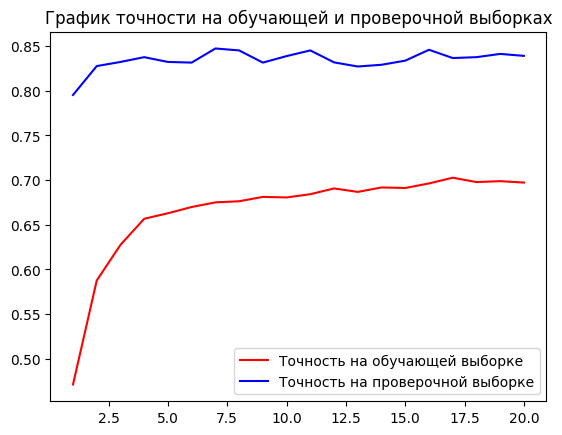

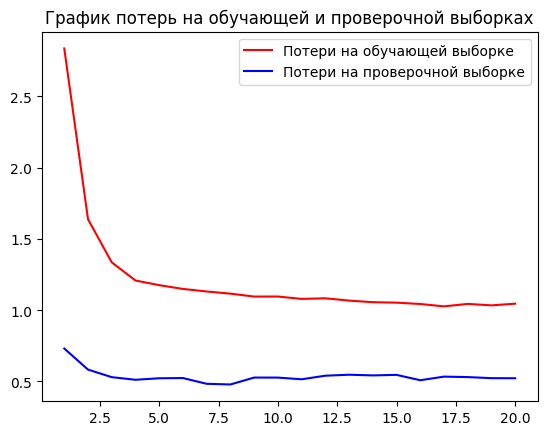

In [ ]:
show_plot(history)

In [ ]:
# Загружаем лучшую модель
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - acc: 0.7068 - loss: 0.9969 - val_acc: 0.8439 - val_loss: 0.5022
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - acc: 0.7102 - loss: 0.9811 - val_acc: 0.8491 - val_loss: 0.4888
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - acc: 0.7197 - loss: 0.9277 - val_acc: 0.8527 - val_loss: 0.4808
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - acc: 0.7245 - loss: 0.9254 - val_acc: 0.8542 - val_loss: 0.4749


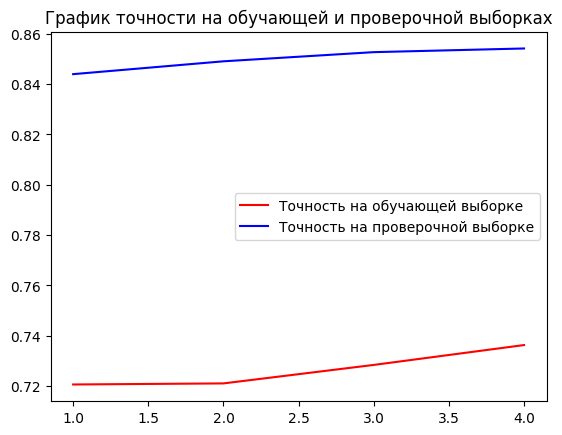

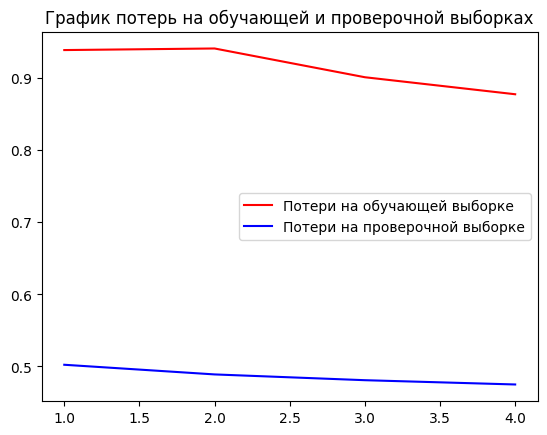

In [ ]:
# Размораживаем модель и уменьшаем шаг обучения
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

--2024-04-01 23:37:43--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K   269KB/s    in 0.2s    

2024-04-01 23:37:44 (269 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


(-0.5, 223.5, 223.5, -0.5)

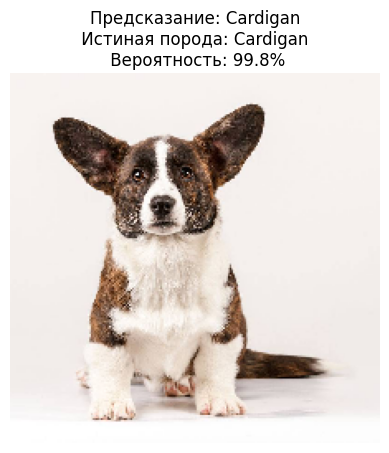

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-01 23:50:21--  https://i.pinimg.com/736x/6b/3a/4c/6b3a4c32659711d333e7e3b0089ef8cc.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.92.84, 2600:1406:4c00::17d6:aa10, 2600:1406:4c00::17d6:aa08, ...
Connecting to i.pinimg.com (i.pinimg.com)|146.75.92.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39303 (38K) [image/jpeg]
Saving to: ‘6b3a4c32659711d333e7e3b0089ef8cc.jpg’

6b3a4c32659711d333e 100%[===================>]  38.38K  --.-KB/s    in 0.002s  

2024-04-01 23:50:21 (21.7 MB/s) - ‘6b3a4c32659711d333e7e3b0089ef8cc.jpg’ saved [39303/39303]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

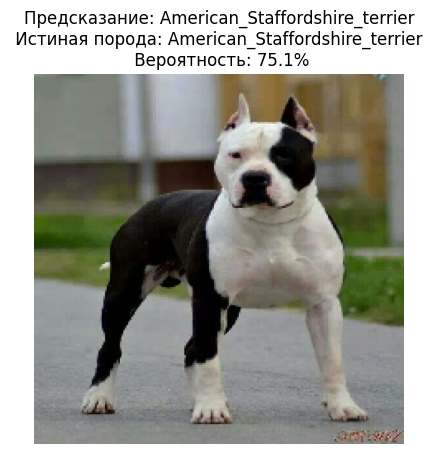

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://i.pinimg.com/736x/6b/3a/4c/6b3a4c32659711d333e7e3b0089ef8cc.jpg
TEST_IMG='./American_Staffordshire_terrier.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: American_Staffordshire_terrier \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-01 23:53:25--  https://www.shutterstock.com/image-photo/young-doberman-female-posing-600nw-1841841697.jpg
Resolving www.shutterstock.com (www.shutterstock.com)... 3.163.125.27, 3.163.125.108, 3.163.125.2, ...
Connecting to www.shutterstock.com (www.shutterstock.com)|3.163.125.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50445 (49K) [image/jpeg]
Saving to: ‘young-doberman-female-posing-600nw-1841841697.jpg.1’

young-doberman-fema 100%[===================>]  49.26K  --.-KB/s    in 0.007s  

2024-04-01 23:53:25 (6.53 MB/s) - ‘young-doberman-female-posing-600nw-1841841697.jpg.1’ saved [50445/50445]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

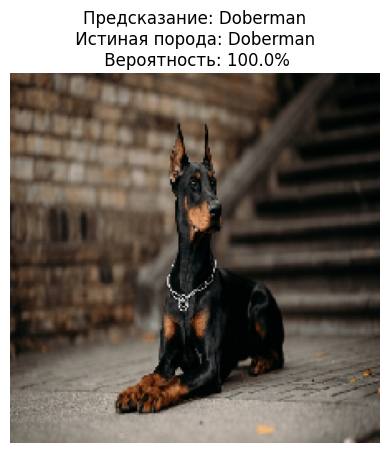

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://www.shutterstock.com/image-photo/young-doberman-female-posing-600nw-1841841697.jpg
TEST_IMG='./young-doberman-female-posing-600nw-1841841697.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Doberman \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-01 23:54:29--  https://cdn.britannica.com/02/236302-050-E1F61BB1/Alaskan-Malamute-sled-dog.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 18.164.154.124, 18.164.154.49, 18.164.154.38, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|18.164.154.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314354 (307K) [image/jpeg]
Saving to: ‘Alaskan-Malamute-sled-dog.jpg’

Alaskan-Malamute-sl 100%[===================>] 306.99K  1.39MB/s    in 0.2s    

2024-04-01 23:54:30 (1.39 MB/s) - ‘Alaskan-Malamute-sled-dog.jpg’ saved [314354/314354]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(-0.5, 223.5, 223.5, -0.5)

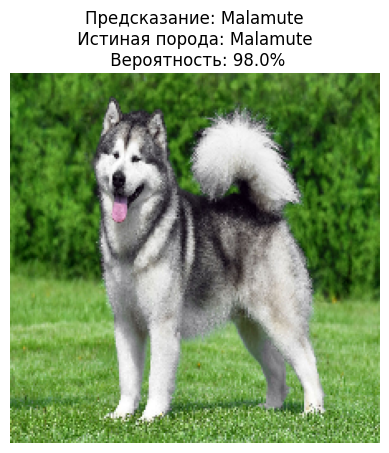

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://cdn.britannica.com/02/236302-050-E1F61BB1/Alaskan-Malamute-sled-dog.jpg
TEST_IMG='./Alaskan-Malamute-sled-dog.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Malamute \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-01 23:57:44--  https://www.k9ofmine.com/wp-content/uploads/2021/06/Breed-information-Rottweilers.jpg
Resolving www.k9ofmine.com (www.k9ofmine.com)... 104.21.63.241, 172.67.173.92, 2606:4700:3035::6815:3ff1, ...
Connecting to www.k9ofmine.com (www.k9ofmine.com)|104.21.63.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78446 (77K) [image/jpeg]
Saving to: ‘Breed-information-Rottweilers.jpg’

Breed-information-R 100%[===================>]  76.61K  --.-KB/s    in 0.008s  

2024-04-01 23:57:45 (9.90 MB/s) - ‘Breed-information-Rottweilers.jpg’ saved [78446/78446]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(-0.5, 223.5, 223.5, -0.5)

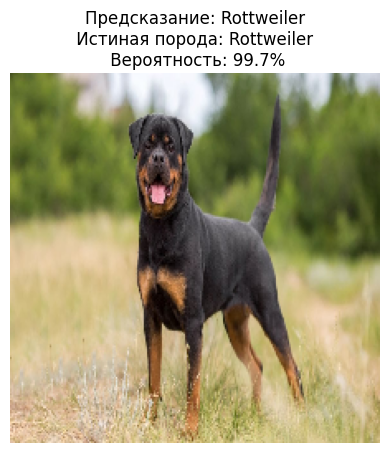

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://www.k9ofmine.com/wp-content/uploads/2021/06/Breed-information-Rottweilers.jpg
TEST_IMG='./Breed-information-Rottweilers.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Rottweiler \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-01 23:58:35--  https://www.plutas.lt/files/images/103884/resized/320x0p/samojedas.jpg
Resolving www.plutas.lt (www.plutas.lt)... 104.21.48.95, 172.67.183.65, 2606:4700:3037::6815:305f, ...
Connecting to www.plutas.lt (www.plutas.lt)|104.21.48.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18725 (18K) [image/jpeg]
Saving to: ‘samojedas.jpg’

samojedas.jpg       100%[===================>]  18.29K  --.-KB/s    in 0s      

2024-04-01 23:58:36 (132 MB/s) - ‘samojedas.jpg’ saved [18725/18725]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


(-0.5, 223.5, 223.5, -0.5)

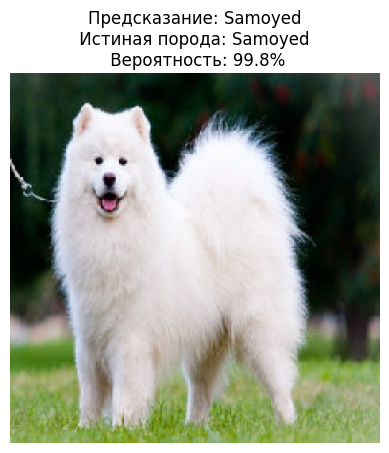

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://www.plutas.lt/files/images/103884/resized/320x0p/samojedas.jpg
TEST_IMG='./samojedas.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Samoyed \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-02 00:00:19--  https://image.jimcdn.com/app/cms/image/transf/dimension=1920x1024:format=jpg/path/sedc436d9c56ca394/image/ie805841f9098169f/version/1649005035/image.jpg
Resolving image.jimcdn.com (image.jimcdn.com)... 151.101.2.2, 151.101.66.2, 151.101.130.2, ...
Connecting to image.jimcdn.com (image.jimcdn.com)|151.101.2.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323017 (315K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 315.45K  --.-KB/s    in 0.02s   

2024-04-02 00:00:19 (13.5 MB/s) - ‘image.jpg’ saved [323017/323017]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


(-0.5, 223.5, 223.5, -0.5)

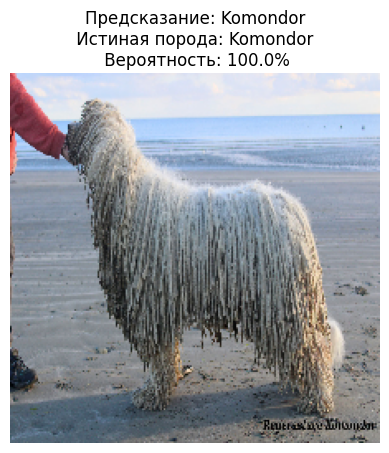

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://image.jimcdn.com/app/cms/image/transf/dimension=1920x1024:format=jpg/path/sedc436d9c56ca394/image/ie805841f9098169f/version/1649005035/image.jpg
TEST_IMG='./image.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Komondor \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-02 00:01:20--  https://upload.wikimedia.org/wikipedia/commons/3/36/Belgian_Groenendael_600.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97248 (95K) [image/jpeg]
Saving to: ‘Belgian_Groenendael_600.jpg’

Belgian_Groenendael 100%[===================>]  94.97K  --.-KB/s    in 0.04s   

2024-04-02 00:01:20 (2.65 MB/s) - ‘Belgian_Groenendael_600.jpg’ saved [97248/97248]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

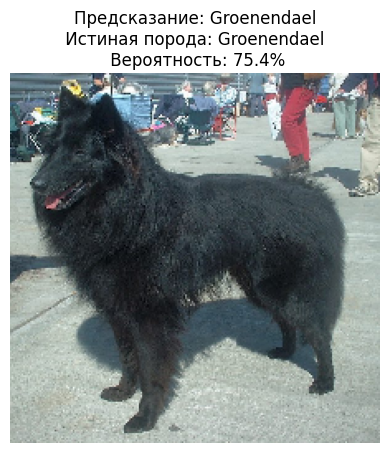

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://upload.wikimedia.org/wikipedia/commons/3/36/Belgian_Groenendael_600.jpg
TEST_IMG='./Belgian_Groenendael_600.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Groenendael \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-02 00:04:13--  https://upload.wikimedia.org/wikipedia/commons/0/07/French_Bulldog.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 886664 (866K) [image/jpeg]
Saving to: ‘French_Bulldog.JPG’

French_Bulldog.JPG  100%[===================>] 865.88K  --.-KB/s    in 0.09s   

2024-04-02 00:04:13 (9.85 MB/s) - ‘French_Bulldog.JPG’ saved [886664/886664]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

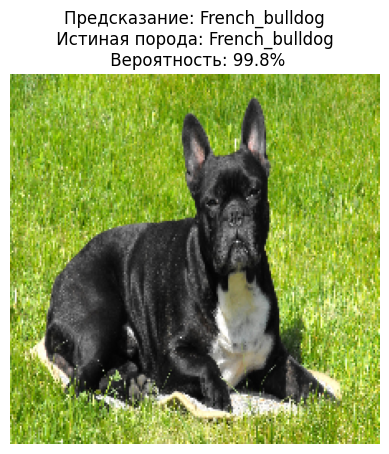

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://upload.wikimedia.org/wikipedia/commons/0/07/French_Bulldog.JPG
TEST_IMG='./French_Bulldog.JPG'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: French_bulldog \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-04-02 00:06:18--  https://upload.wikimedia.org/wikipedia/commons/f/f7/Adult_Rough_Collie.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3867721 (3.7M) [image/jpeg]
Saving to: ‘Adult_Rough_Collie.JPG’

Adult_Rough_Collie. 100%[===================>]   3.69M  12.0MB/s    in 0.3s    

2024-04-02 00:06:19 (12.0 MB/s) - ‘Adult_Rough_Collie.JPG’ saved [3867721/3867721]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(-0.5, 223.5, 223.5, -0.5)

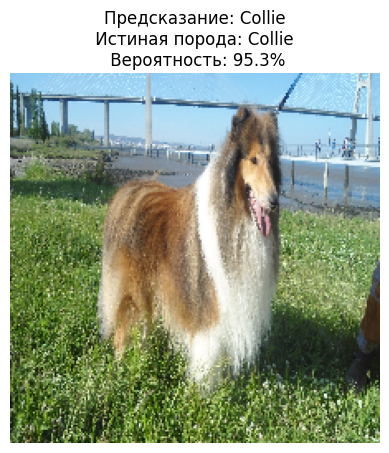

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://upload.wikimedia.org/wikipedia/commons/f/f7/Adult_Rough_Collie.JPG
TEST_IMG='./Adult_Rough_Collie.JPG'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Collie \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")